In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, mean_squared_error
import tensorflow as tf

In [3]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 100 # number of cycles to run
ALPHA = 0.01 # learning rate
WEIGHT_DECAY = 0.001
BATCH_SIZE = 32
TRAIN_SIZE = BATCH_SIZE * 9

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [5]:
data_df = pd.read_csv('weatherHistory.csv')
data_df.shape

(96453, 12)

In [6]:
cols = data_df.columns

for col in cols:
    print(f'\n Columsn Name: {col}: {data_df[col].unique()}')


 Columsn Name: Formatted Date: ['2006-04-01 00:00:00.000 +0200' '2006-04-01 01:00:00.000 +0200'
 '2006-04-01 02:00:00.000 +0200' ... '2016-09-09 21:00:00.000 +0200'
 '2016-09-09 22:00:00.000 +0200' '2016-09-09 23:00:00.000 +0200']

 Columsn Name: Summary: ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']

 Columsn Name: Precip Type: ['rain' 'snow' nan]

 Columsn Name: Temperature (C): [ 9.47222222  9.35555556  9.37777778 ... 28.47222222 28.33888889
 30.60555556]

 Columsn Name: Apparent Temperature (C): [ 7.38888889  7.22777778  9.37777778 ... 

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [8]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [10]:
temp_df = data_df[['datetime', 'Temperature (C)', 'Humidity']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)

In [11]:
temp_df.reset_index(inplace=True, drop = True)
temp_df = temp_df.rename({'Temperature (C)': 'temp', 'Humidity': 'hum'}, axis = 1)

In [12]:
temp_df.head()

,datetime,temp,hum
0,2005-12-31 23:00:00+00:00,0.577778,0.89
1,2006-01-01 00:00:00+00:00,1.161111,0.85
2,2006-01-01 01:00:00+00:00,1.666667,0.82
3,2006-01-01 02:00:00+00:00,1.711111,0.82
4,2006-01-01 03:00:00+00:00,1.183333,0.86


In [13]:
temp_df.shape

(96453, 3)

In [14]:
#if you want to truncate your data using time stamp

# startDate = pd.to_datetime('2007-1-1', utc = True)
# endDate   = pd.to_datetime('2008-1-1', utc = True)

# temp_df = temp_df[(temp_df['datetime']>=startDate)
# &(temp_df['datetime'<endDate])]

# temp_df.shape

<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

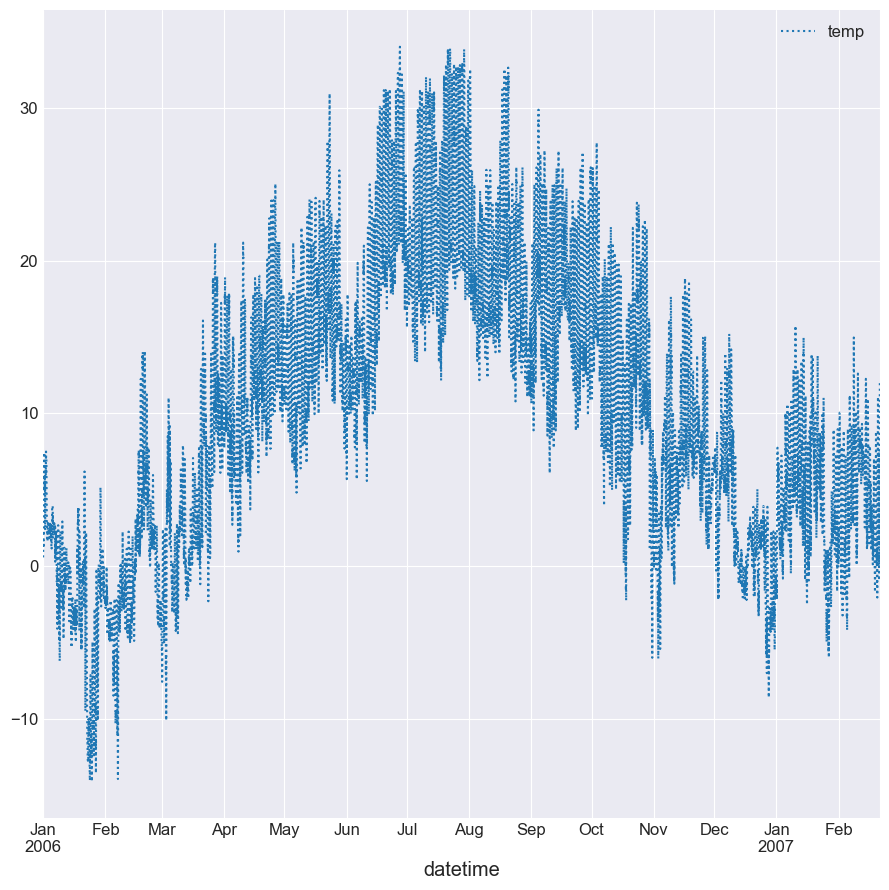

In [15]:
temp_df[:10000].plot(x = 'datetime', y= 'temp', style = ':')
plt.tight_layout()
plt.legend()
plt.grid

In [16]:
input_shape = (1,10_000)
n_units = 100
model_gigo = tf.keras.Sequential()

model_gigo.add(tf.keras.Input(input_shape))

model_gigo.add(tf.keras.layers.SimpleRNN(units = n_units, activation='tanh'))  #check documentation

model_gigo.add(tf.keras.layers.Dense(units = 1, activation='linear'))  #check documentation

In [17]:
model_gigo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │       1,010,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
wax = model_gigo.get_weights()[0].shape
waa = model_gigo.get_weights()[1].shape
baa = model_gigo.get_weights()[2].shape

way = model_gigo.get_weights()[3].shape
bay = model_gigo.get_weights()[4].shape

print(f'Wax :{wax} | Waa : {waa} | Baa : {baa}')

print(f'Way :{way} | Bay : {bay} ')

Wax :(10000, 100) | Waa : (100, 100) | Baa : (100,)
Way :(100, 1) | Bay : (1,) 


In [19]:
del model_gigo, data_df

In [20]:
temp_df

,datetime,temp,hum
0,2005-12-31 23:00:00+00:00,0.577778,0.89
1,2006-01-01 00:00:00+00:00,1.161111,0.85
2,2006-01-01 01:00:00+00:00,1.666667,0.82
3,2006-01-01 02:00:00+00:00,1.711111,0.82
4,2006-01-01 03:00:00+00:00,1.183333,0.86
...,...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889,0.86
96449,2016-12-31 19:00:00+00:00,0.072222,0.88
96450,2016-12-31 20:00:00+00:00,-0.233333,0.89
96451,2016-12-31 21:00:00+00:00,-0.472222,0.91


In [21]:
time_step = 24
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx][['datetime', 'temp']]
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [22]:
y_df.shape, len(y_df)*time_step, temp_df.shape

((4018, 2), 96432, (96453, 3))

In [23]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 3)

In [24]:
X_tmp = np.reshape(X_df['temp'].to_numpy(), (y_df.shape[0], time_step))
X_hum = np.reshape(X_df['hum'].to_numpy(), (y_df.shape[0], time_step))
X_tmp.shape, X_hum.shape

((4018, 24), (4018, 24))

In [25]:
X = np.stack((X_tmp, X_hum), axis = 2)
X.shape

(4018, 24, 2)

In [26]:
X = X[:, :23, : ] #last col drop by double slicing 
X.shape

(4018, 23, 2)

In [27]:
y  = y_df.temp.to_numpy()
y

array([ 5.42222222,  1.69444444,  2.2       , ..., -1.72777778,
       -1.77777778, -1.82222222])

In [28]:
split = int(BATCH_SIZE*100)# y_df.shape[0]*0.8//32
split

3200

In [29]:
X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 23, 2), (818, 23, 2), (3200,), (818,))

In [30]:
input_shape = (time_step-1, X_train.shape[2]) #2 features
n_units = 128
model = tf.keras.Sequential()

model.add(tf.keras.Input(input_shape))

model.add(tf.keras.layers.SimpleRNN(units = n_units, activation='tanh'))  #check documentation

model.add(tf.keras.layers.Dense(units = 1, activation='linear'))  #check documentation

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          16,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
metrics = tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [33]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test,y_test))

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 49.5755 - root_mean_squared_error: 6.7842 - val_loss: 2.2609 - val_root_mean_squared_error: 1.5036
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5069 - root_mean_squared_error: 1.8617 - val_loss: 1.3010 - val_root_mean_squared_error: 1.1406
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7162 - root_mean_squared_error: 1.3092 - val_loss: 0.8242 - val_root_mean_squared_error: 0.9079
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5006 - root_mean_squared_error: 1.2235 - val_loss: 0.7434 - val_root_mean_squared_error: 0.8622
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3182 - root_mean_squared_error: 1.1476 - val_loss: 0.7125 - val_root_mean_squared_error: 0.8441
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1178 - root_mean_squared_error: 1.0566 - val_loss: 0.7861 - val_root_mean_squared_error: 0.8866
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [34]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,22.076427,4.698556,2.260894,1.503627
1,2.744721,1.656720,1.301047,1.140635
2,1.708825,1.307220,0.824208,0.907859
3,1.509446,1.228595,0.743439,0.862229
4,1.255728,1.120593,0.712549,0.844126


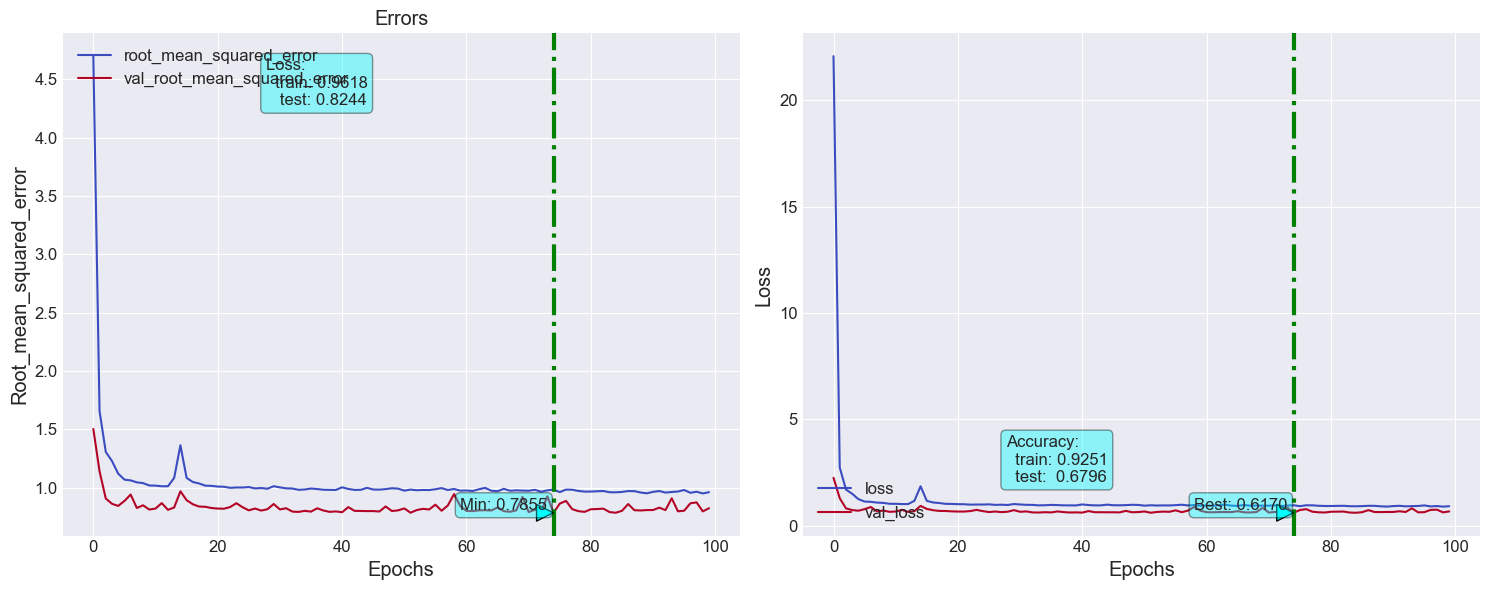

In [81]:
fn_plot_tf_hist(loss_df)
plt.tight_layout()

In [36]:
y_train_pred = model(X_train)
y_test_pred  = model(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

In [37]:
y_pred.shape

(4018,)

In [39]:
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,5.063835
48,2006-01-02,1.694444,1.430964
72,2006-01-03,2.200000,1.770109
96,2006-01-04,1.666667,1.673267
120,2006-01-05,1.805556,2.074587


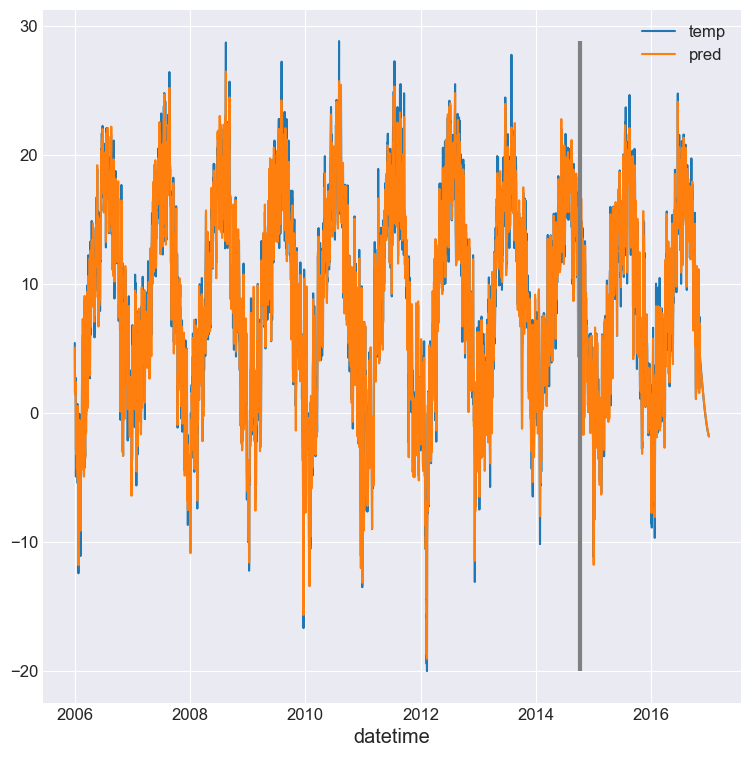

In [40]:
ax = res_df.plot(x = 'datetime', y= ['temp', 'pred'])

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'],
        res_df['temp'].min(), res_df['temp'].max(),
        color = 'gray', linewidth = 3.0)